<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- ASSUMES USING DOCKER, see readme for instructions

<a id='1.1'></a>
## 2.1. Add FinRL to your path. You can of course install it as a pipy package, but this is for development purposes.


In [1]:
import sys

sys.path.append("..")

In [2]:
import pandas as pd
print(pd.__version__)

1.1.5



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading_cashpenalty import StockTradingEnvCashpenalty
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_plot, backtest_stats

from pprint import pprint

/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [6]:
# from config.py end_date is a string
config.END_DATE

'2021-01-01'

In [7]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [8]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=False,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


In [10]:
processed['log_volume'] = np.log(processed.volume*processed.close)
processed['change'] = (processed.close-processed.open)/processed.close
processed['daily_variance'] = (processed.high-processed.low)/processed.close
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,log_volume,change,daily_variance
0,2009-01-02,3.067143,3.251429,3.041429,2.791740,746015200,AAPL,4,0.000000,3.017278,2.684025,100.000000,66.666667,100.000000,2.791740,2.791740,21.456922,-0.098649,0.075222
1,2009-01-02,18.570000,19.520000,18.400000,15.745411,10955700,AXP,4,0.002643,3.017278,2.684025,100.000000,66.666667,100.000000,2.850651,2.850651,18.965919,-0.179391,0.071132
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,0.001880,2.972787,2.735796,70.355711,46.771878,100.000000,2.854292,2.854292,19.287503,-0.261008,0.081907
3,2009-01-02,44.910000,46.980000,44.709999,32.978760,7117200,CAT,4,-0.000746,2.951725,2.729582,50.429389,-29.777993,43.607834,2.840654,2.840654,19.273889,-0.361786,0.068832
4,2009-01-02,16.410000,17.000000,16.250000,12.683227,40980600,CSCO,4,-0.000088,2.939568,2.746169,60.227126,-9.019317,48.357918,2.842869,2.842869,20.068890,-0.293835,0.059133


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2016-01-01
## Trade data split: 2016-01-01 to 2021-01-01

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2016-01 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [11]:
train = data_split(processed, '2009-01-01','2016-01-01')
trade = data_split(processed, '2016-01-01','2021-01-01')
print(len(train))
print(len(trade))

52860
37770


In [12]:
print(StockTradingEnvCashpenalty.__doc__)


    A stock trading environment for OpenAI gym
    This environment penalizes the model for not maintaining a reserve of cash.
    This enables the model to manage cash reserves in addition to performing trading procedures.
    Reward at any step is given as follows
        r_i = (sum(cash, asset_value) - initial_cash - max(0, sum(cash, asset_value)*cash_penalty_proportion-cash))/(days_elapsed)
        This reward function takes into account a liquidity requirement, as well as long-term accrued rewards.
    Parameters:
        df (pandas.DataFrame): Dataframe containing data
        buy_cost_pct (float): cost for buying shares
        sell_cost_pct (float): cost for selling shares
        hmax (int, array): maximum cash to be traded in each trade per asset. If an array is provided, then each index correspond to each asset
        discrete_actions (bool): option to choose whether perform dicretization on actions space or not
        shares_increment (int): multiples number of shares ca

#### state space
The state space of the observation is as follows 

`start_cash, <owned_shares_of_n_assets>, <<indicator_i_for_asset_j> for j in assets>`

indicators are any daily measurement you can achieve. Common ones are 'volume', 'open' 'close' 'high', 'low'.
However, you can add these as needed, 
The feature engineer adds indicators, and you can add your own as well. 


In [13]:
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,log_volume,change,daily_variance
0,2009-01-02,3.067143,3.251429,3.041429,2.791740,746015200,AAPL,4,0.000000,3.017278,2.684025,100.000000,66.666667,100.000000,2.791740,2.791740,21.456922,-0.098649,0.075222
1,2009-01-02,18.570000,19.520000,18.400000,15.745411,10955700,AXP,4,0.002643,3.017278,2.684025,100.000000,66.666667,100.000000,2.850651,2.850651,18.965919,-0.179391,0.071132
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,0.001880,2.972787,2.735796,70.355711,46.771878,100.000000,2.854292,2.854292,19.287503,-0.261008,0.081907
3,2009-01-02,44.910000,46.980000,44.709999,32.978760,7117200,CAT,4,-0.000746,2.951725,2.729582,50.429389,-29.777993,43.607834,2.840654,2.840654,19.273889,-0.361786,0.068832
4,2009-01-02,16.410000,17.000000,16.250000,12.683227,40980600,CSCO,4,-0.000088,2.939568,2.746169,60.227126,-9.019317,48.357918,2.842869,2.842869,20.068890,-0.293835,0.059133


In [14]:
information_cols = ['daily_variance', 'change', 'log_volume', 'close','day', 
                    'macd', 'rsi_30', 'cci_30', 'dx_30']

e_train_gym = StockTradingEnvCashpenalty(df = train,initial_amount = 1e6,hmax = 5000, 
                                turbulence_threshold = None, 
                                currency='$',
                                buy_cost_pct=3e-3,
                                sell_cost_pct=3e-3,
                                cash_penalty_proportion=0.2,
                                cache_indicator_data=True,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500, 
                                random_start = True)

e_trade_gym = StockTradingEnvCashpenalty(df = trade,initial_amount = 1e6,hmax = 5000, 
                                turbulence_threshold = None, 
                                currency='$',
                                buy_cost_pct=3e-3,
                                sell_cost_pct=3e-3,
                                cash_penalty_proportion=0.2,
                                cache_indicator_data=True,
                                daily_information_cols = information_cols, 
                                print_verbosity = 500, 
                                random_start = False)

caching data
data cached!
caching data
data cached!


## Environment for Training
There are two available environments. The multiprocessing and the single processing env. 
Some models won't work with multiprocessing. 

```python
# single processing
env_train, _ = e_train_gym.get_sb_env()


#multiprocessing
env_train, _ = e_train_gym.get_multiproc_env(n = <n_cores>)
```


In [15]:
# single processing
env_train, _ = e_train_gym.get_sb_env()

#this is our observation environment. It allows full diagnostics
env_trade, _ = e_trade_gym.get_sb_env()

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [16]:
agent = DRLAgent(env = env_train)

### Model PPO


In [17]:
# from torch.nn import Softsign, ReLU
ppo_params ={'n_steps': 256, 
             'ent_coef': 0.0, 
             'learning_rate': 0.000005, 
             'batch_size': 1024, 
            'gamma': 0.99}

policy_kwargs = {
#     "activation_fn": ReLU,
    "net_arch": [1024 for _ in range(10)], 
#     "squash_output": True
}

model = agent.get_model("ppo",  
                        model_kwargs = ppo_params, 
                        policy_kwargs = policy_kwargs, verbose = 0)

# model = model.load("scaling_reward.model", env = env_train)

{'n_steps': 256, 'ent_coef': 0.0, 'learning_rate': 5e-06, 'batch_size': 1024, 'gamma': 0.99}


In [18]:
model.learn(total_timesteps = 20000, 
            eval_env = env_trade, 
            eval_freq = 500,
            log_interval = 1, 
            tb_log_name = 'env_cashpenalty_highlr',
            n_eval_episodes = 1)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 161|CASH SHORTAGE  |$30,528        |$951,371       |-0.12943% |-4.86295% |3.21%     
   2| 171|CASH SHORTAGE  |$1,624         |$948,514       |-0.14010% |-5.14858% |0.17%     
   3|  87|CASH SHORTAGE  |$23,931        |$972,976       |-0.22723% |-2.70244% |2.46%     


/opt/conda/lib/python3.6/site-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 499|update         |$568,339       |$1,155,518     |0.03123%  |15.55181% |49.18%    
   1| 999|update         |$137,976       |$1,281,897     |0.01638%  |28.18973% |10.76%    
   1|1173|CASH SHORTAGE  |$195           |$1,231,173     |-0.00127% |23.11728% |0.02%     
Eval num_timesteps=500, episode_reward=0.18 +/- 0.00
Episode length: 1174.00 +/- 0.00
New best mean reward!
   4| 189|CASH SHORTAGE  |$13,429        |$1,099,732     |-0.05650% |9.97320%  |1.22%     
   5| 116|CASH SHORTAGE  |$6,235         |$911,293       |-0.22822% |-8.87074% |0.68%     
   6| 112|CASH SHORTAGE  |$37,861        |$931,615       |-0.19361% |-6.83849% |4.06%     
   3| 499|update         |$212,525       |$1,243,857     |0.04169%  |24.38574% |17.09%    
   3| 653|CASH SHORTAGE  |$135           |$1,258,012     |0.00100%  |25.80123% |0.01%     
Eval num_timesteps=1000, episode_reward=0.11 +/- 0.0

In [19]:
model.save("different3_15_20000.model")

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [20]:
trade.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,log_volume,change,daily_variance
0,2016-01-04,25.652500,26.342501,25.500000,24.364536,270597600,AAPL,0,-0.042087,50.977331,46.868874,51.257871,-35.522943,2.464367,48.839511,47.986399,22.609272,-0.052862,0.034579
0,2016-01-04,68.089996,68.180000,66.769997,62.056198,9248300,AXP,0,-0.144976,51.043534,46.670979,46.288349,-143.982037,16.596925,48.807629,47.962266,20.167991,-0.097231,0.022721
0,2016-01-04,141.380005,141.699997,139.429993,126.005096,5719500,BA,0,-0.207474,51.074521,46.521561,47.047042,-147.508365,16.596925,48.767333,47.943346,20.395714,-0.122018,0.018015
0,2016-01-04,66.879997,68.080002,65.720001,58.213009,8586900,CAT,0,-0.233005,51.062979,46.407497,48.019277,-114.189261,14.599622,48.737479,47.936612,20.029857,-0.148884,0.040541
0,2016-01-04,26.389999,26.420000,25.879999,22.478188,35827100,CSCO,0,-0.253644,50.991839,46.295658,47.877226,-110.586296,15.946361,48.699970,47.927278,20.506761,-0.174027,0.024023


In [21]:
e_trade_gym.hmax = 5000

In [22]:
print(len(e_trade_gym.dates))

1259


In [23]:
e_trade_gym.patient = True
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model,environment = e_trade_gym)

EPISODE|STEPS|TERMINAL_REASON|CASH           |TOT_ASSETS     |TERMINAL_REWARD_unsc|GAINLOSS_PCT|CASH_PROPORTION
   1| 101|CASH SHORTAGE  |$8,873         |$1,031,664     |-0.16415% |3.16644%  |0.86%     
   1| 105|CASH SHORTAGE  |$23,527        |$1,029,345     |-0.14571% |2.93452%  |2.29%     
   1| 114|CASH SHORTAGE  |$25,574        |$1,025,096     |-0.13539% |2.50963%  |2.49%     
   1| 116|CASH SHORTAGE  |$633           |$1,027,293     |-0.15304% |2.72932%  |0.06%     
   1| 121|CASH SHORTAGE  |$21,903        |$992,744       |-0.15198% |-0.72557% |2.21%     
   1| 126|CASH SHORTAGE  |$18,913        |$1,029,605     |-0.12492% |2.96054%  |1.84%     
   1| 136|CASH SHORTAGE  |$17,240        |$1,065,583     |-0.09580% |6.55833%  |1.62%     
   1| 143|CASH SHORTAGE  |$7,763         |$1,062,703     |-0.09935% |6.27026%  |0.73%     
   1| 155|CASH SHORTAGE  |$28,041        |$1,075,658     |-0.07189% |7.56575%  |2.61%     
   1| 165|CASH SHORTAGE  |$31,183        |$1,074,808     |-0.06604% |

In [24]:
df_actions.head()

,date,actions,transactions
0,2016-01-05,"[1.0, -0.468488, -0.24443227, -0.30354565, 0.1...","[205.21630050460175, -0.0, -0.0, -0.0, 23.2135..."
1,2016-01-06,"[0.7459344, -1.0, 1.0, -0.0844269, 0.62084204,...","[157.0125350843208, -0.0, 39.520600450685365, ..."
2,2016-01-07,"[0.4252786, 0.10746241, 0.8404744, -1.0, 1.0, ...","[91.30415577004283, 9.04495876945578, 33.75198..."
3,2016-01-08,"[1.0, -0.16098602, 0.68717164, 0.026218427, 1....","[224.15284914924715, -9.04495876945578, 28.803..."
4,2016-01-11,"[0.32652092, -1.0, 0.4602956, 1.0, -0.62493354...","[72.80562708205481, -0.0, 19.741722770517374, ..."


In [25]:
df_account_value.shape

(1258, 5)

In [26]:
df_account_value.head(50)

,cash,asset_value,total_assets,reward,date
0,1000000.000000,0.000000,1.000000e+06,0.000000,2016-01-05
1,979781.337144,20144.808974,9.999261e+05,-0.000074,2016-01-06
2,938695.313369,60396.773737,9.990921e+05,-0.000454,2016-01-07
3,889103.721743,107665.201742,9.967689e+05,-0.001077,2016-01-08
4,851819.649180,142997.742396,9.948174e+05,-0.001296,2016-01-11
5,803586.195913,192135.124772,9.957213e+05,-0.000856,2016-01-12
6,791812.436088,205054.563231,9.968670e+05,-0.000522,2016-01-13
7,768095.383910,223759.162356,9.918545e+05,-0.001164,2016-01-14
8,774908.319064,219635.142983,9.945435e+05,-0.000682,2016-01-15
9,755892.464818,232910.610406,9.888031e+05,-0.001244,2016-01-19


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [27]:
print("==============Get Backtest Results===========")
perf_stats_all = backtest_stats(account_value=df_account_value, value_col_name = 'total_assets')

==============Get Backtest Results===========
Annual return          0.137586
Cumulative returns     0.903164
Annual volatility      0.190834
Sharpe ratio           0.771981
Calmar ratio           0.398542
Stability              0.941053
Max drawdown          -0.345223
Omega ratio            1.181459
Sortino ratio          1.079074
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.912417
Daily value at risk   -0.023458
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1259, 8)


Start date,2016-01-05
End date,2020-12-31
Total months,59
,Backtest
Annual return,13.759%
Cumulative returns,90.316%
Annual volatility,19.083%
Sharpe ratio,0.77
Calmar ratio,0.40
Stability,0.94
Max drawdown,-34.522%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.52,2020-02-20,2020-03-24,2020-08-27,136
1,16.76,2018-09-24,2018-12-26,2019-04-15,146
2,10.24,2018-01-29,2018-03-26,2018-07-26,129
3,9.97,2020-09-03,2020-11-02,2020-12-02,65
4,7.01,2019-05-01,2019-06-03,2019-06-21,38


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


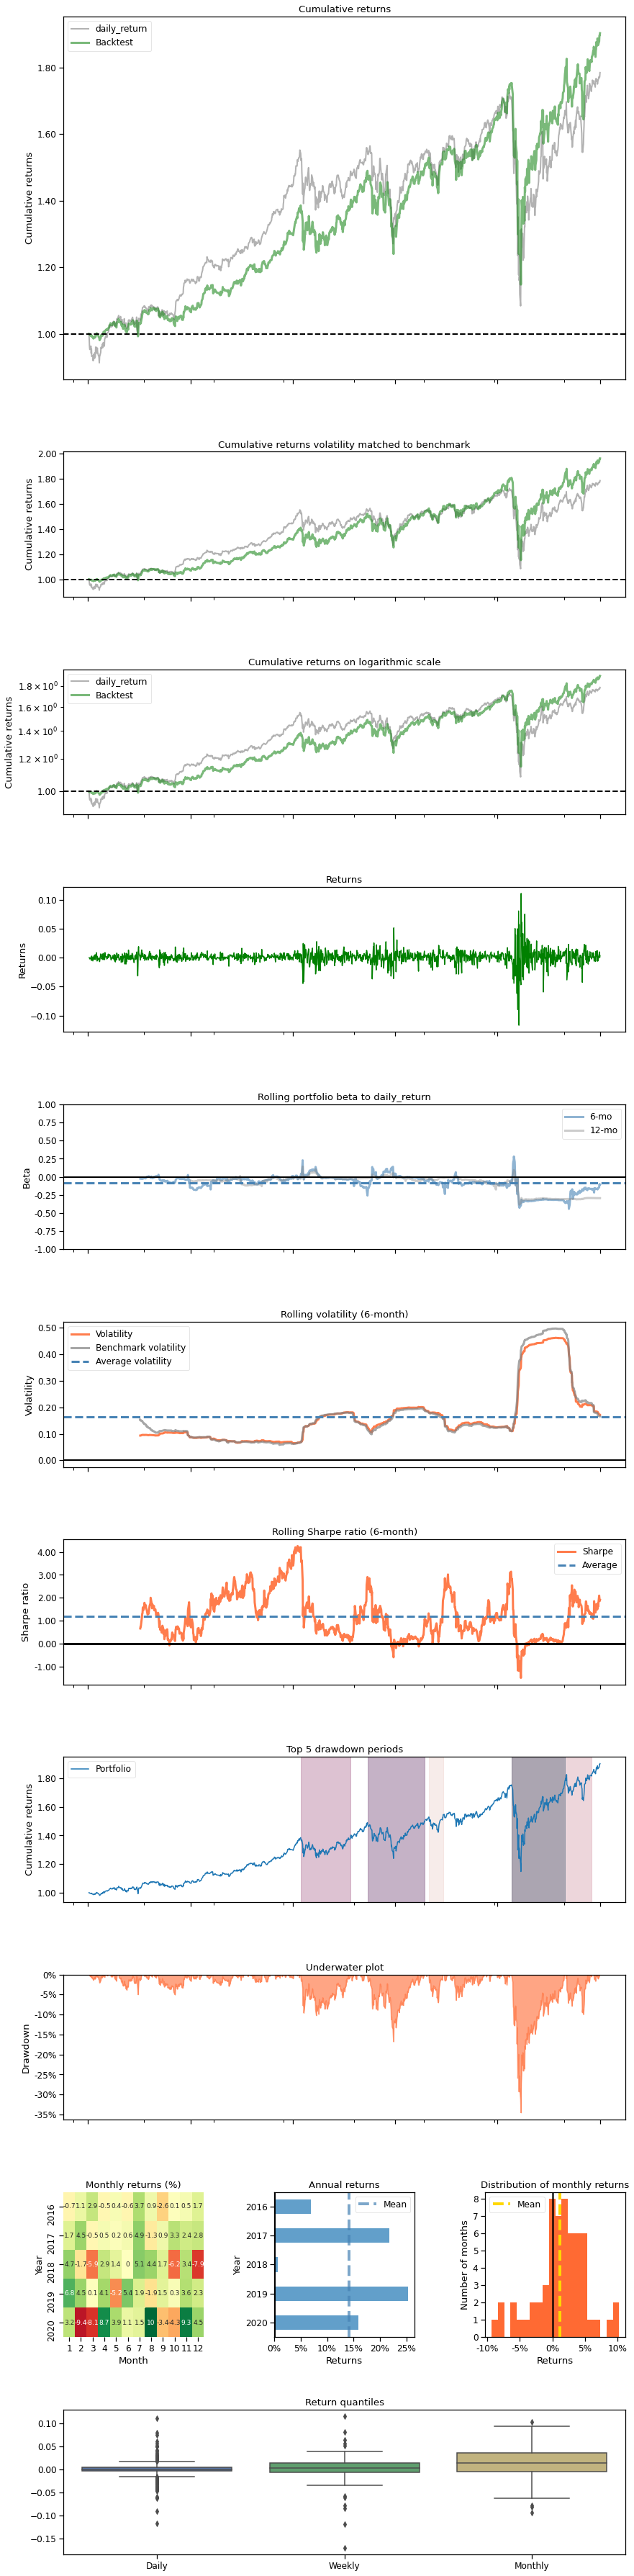

In [28]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2016-01-01',
             baseline_end = '2021-01-01', value_col_name = 'total_assets')